In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import yfinance as yf
import pandas_datareader as pdr
from statsmodels import api as sm
from ta import add_all_ta_features
from re import match

sns.set()
sns.set(rc={'figure.figsize':(30,8)})
SNS_CMAP = sns.light_palette("seagreen", as_cmap=True)
SNS_COLOR = sns.color_palette('muted')

ModuleNotFoundError: No module named 'pandas'

# Preparation: data

In [18]:
symbol = 'SPY'
prc = yf.download(symbol)

[*********************100%***********************]  1 of 1 completed

1 Failed download:
- SPY: No data found for this date range, symbol may be delisted


In [11]:
prc.dropna(inplace=True)

In [ ]:
lnprc = np.log(prc['Adj Close'])
prc_ta = add_all_ta_features(prc,
                             open="Open",
                             high="High",
                             low="Low",
                             close="Close",
                             volume="Volume",
                             fillna=True)
#ta_crossprc = prc_ta.sub(prc['Close'],axis=0)
#ta_crossprc.columns = ta_crossprc.columns.map(lambda x: f'{x}_crossprc')

#prc_ta = pd.concat([prc_ta,ta_crossprc],axis=1)

# Normalize signals by time series

## Normalization methods

In [ ]:
class Norm():
  def __init__():
    pass
  def percentile_ts(data,window=None):
    if window is None:
      percentile = data.expanding(min_periods=252).rank(pct=True)
      center_zero = percentile * 2 - 1
      return center_zero
    else:
      percentile = data.rolling(window=window).rank(pct=True)
      center_zero = percentile * 2 - 1
      return center_zero
  def absmeanscaled_ts(data,window=None):
    if window is None:
      absmean = data.abs().expanding(min_periods=252).mean()
      mean = data.expanding(min_periods=252).mean()
      absmeanscaled = (data - mean) / absmean
      scalar = 1/2
      return absmeanscaled * scalar
    else:
      absmean = data.abs().rolling(window=window).mean()
      mean = data.rolling(window=window).mean()
      absmeanscaled = (data - mean) / absmean
      scalar = 1/2
      return absmeanscaled * scalar
  def zscore_ts(data,window=None):
    if window is None:
      mean = data.expanding(min_periods=252).mean()
      std = data.expanding(min_periods=252).std()
      zscore = (data - mean)/std
      scalar = 1/2
      return zscore * scalar
    else:
      mean = data.rolling(window=window).mean()
      std = data.rolling(window=window).std()
      zscore = (data - mean)/std
      scalar = 1/2
      return zscore * scalar

## Normalize

In [ ]:
lnta = prc_ta.pct_change()
ta_data = prc_ta
window = 252 # None: expanding

norm_ta_data = dict()
norm_ta_data['raw'] = ta_data
norm_ta_data['pct'] = Norm.percentile_ts(ta_data,window)
norm_ta_data['zsc'] = Norm.zscore_ts(ta_data,window)
norm_ta_data['ams'] = Norm.absmeanscaled_ts(ta_data,window)

In [ ]:
# Drop columns where missing rate > 0.10
for key in norm_ta_data.keys():
  data = norm_ta_data[key]
  print(key)
  print(len(norm_ta_data[key].columns))
  print(data.isna().mean().max())
  print(data.isna().mean().quantile(0.9))
  print(data.isna().mean().median())
  print(data.isna().mean().min())
  norm_ta_data[key] = data.loc[:,data.isna().mean()<0.10]
  print(len(norm_ta_data[key].columns))

raw
92
0.0
0.0
0.0
0.0
92
pct
92
0.032183613283754325
0.032183613283754325
0.032183613283754325
0.032183613283754325
92
zsc
92
0.037312475958456215
0.032183613283754325
0.032183613283754325
0.032183613283754325
92
ams
92
0.037312475958456215
0.032183613283754325
0.032183613283754325
0.032183613283754325
92


In [ ]:
#fig,axes = plt.subplots(1,4)
#for i,data in enumerate(norm_ta_data.values()):
#  data.plot(ax=axes[i])

# Group indicator by styles

In [ ]:
ta_names = prc_ta.columns.to_list()[6:]

In [ ]:
ta_groups = dict()
for name in ta_names:
  style = name.split('_')
  try:
    ta_groups[style[0]].add(style[1])
  except:
    ta_groups[style[0]] = set()
    ta_groups[style[0]].add(style[1])

ta_groups

{'volume': {'adi',
  'cmf',
  'em',
  'fi',
  'mfi',
  'nvi',
  'obv',
  'sma',
  'vpt',
  'vwap'},
 'volatility': {'atr',
  'bbh',
  'bbhi',
  'bbl',
  'bbli',
  'bbm',
  'bbp',
  'bbw',
  'dch',
  'dcl',
  'dcm',
  'dcp',
  'dcw',
  'kcc',
  'kch',
  'kchi',
  'kcl',
  'kcli',
  'kcp',
  'kcw',
  'ui'},
 'trend': {'adx',
  'aroon',
  'cci',
  'dpo',
  'ema',
  'ichimoku',
  'kst',
  'macd',
  'mass',
  'psar',
  'sma',
  'stc',
  'trix',
  'visual',
  'vortex'},
 'momentum': {'ao',
  'kama',
  'ppo',
  'pvo',
  'roc',
  'rsi',
  'stoch',
  'tsi',
  'uo',
  'wr'},
 'others': {'cr', 'dlr', 'dr'}}

# Predictability of indicators

In [ ]:
ta_groups.keys()

dict_keys(['volume', 'volatility', 'trend', 'momentum', 'others'])

In [ ]:
group_name = 'others'
group = ta_groups[group_name]
column_names = list(filter(lambda name: match(f'{group_name}_*', name), ta_names))

In [ ]:
norm_method = 'zsc'
norm_ta = norm_ta_data[norm_method]
norm_ta = norm_ta.loc[:,norm_ta.columns.isin(column_names)]

## Correlation matrix

<Axes: >

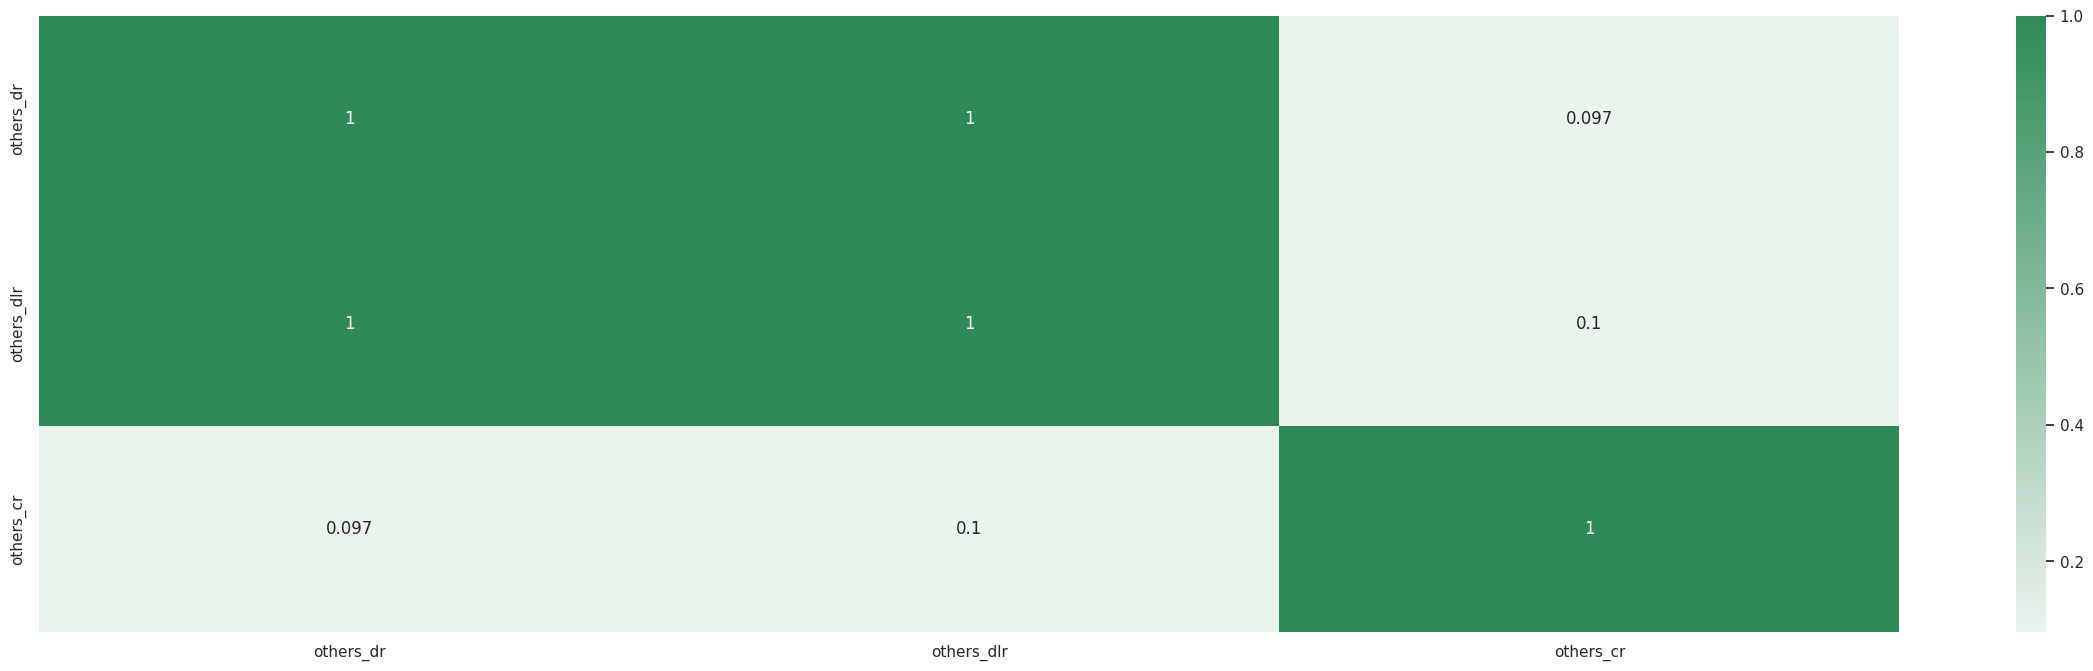

In [ ]:
sns.heatmap(norm_ta.corr(),annot=True,cmap=SNS_CMAP)

## Correlation to return

<Axes: title={'center': 'others_zsc'}>

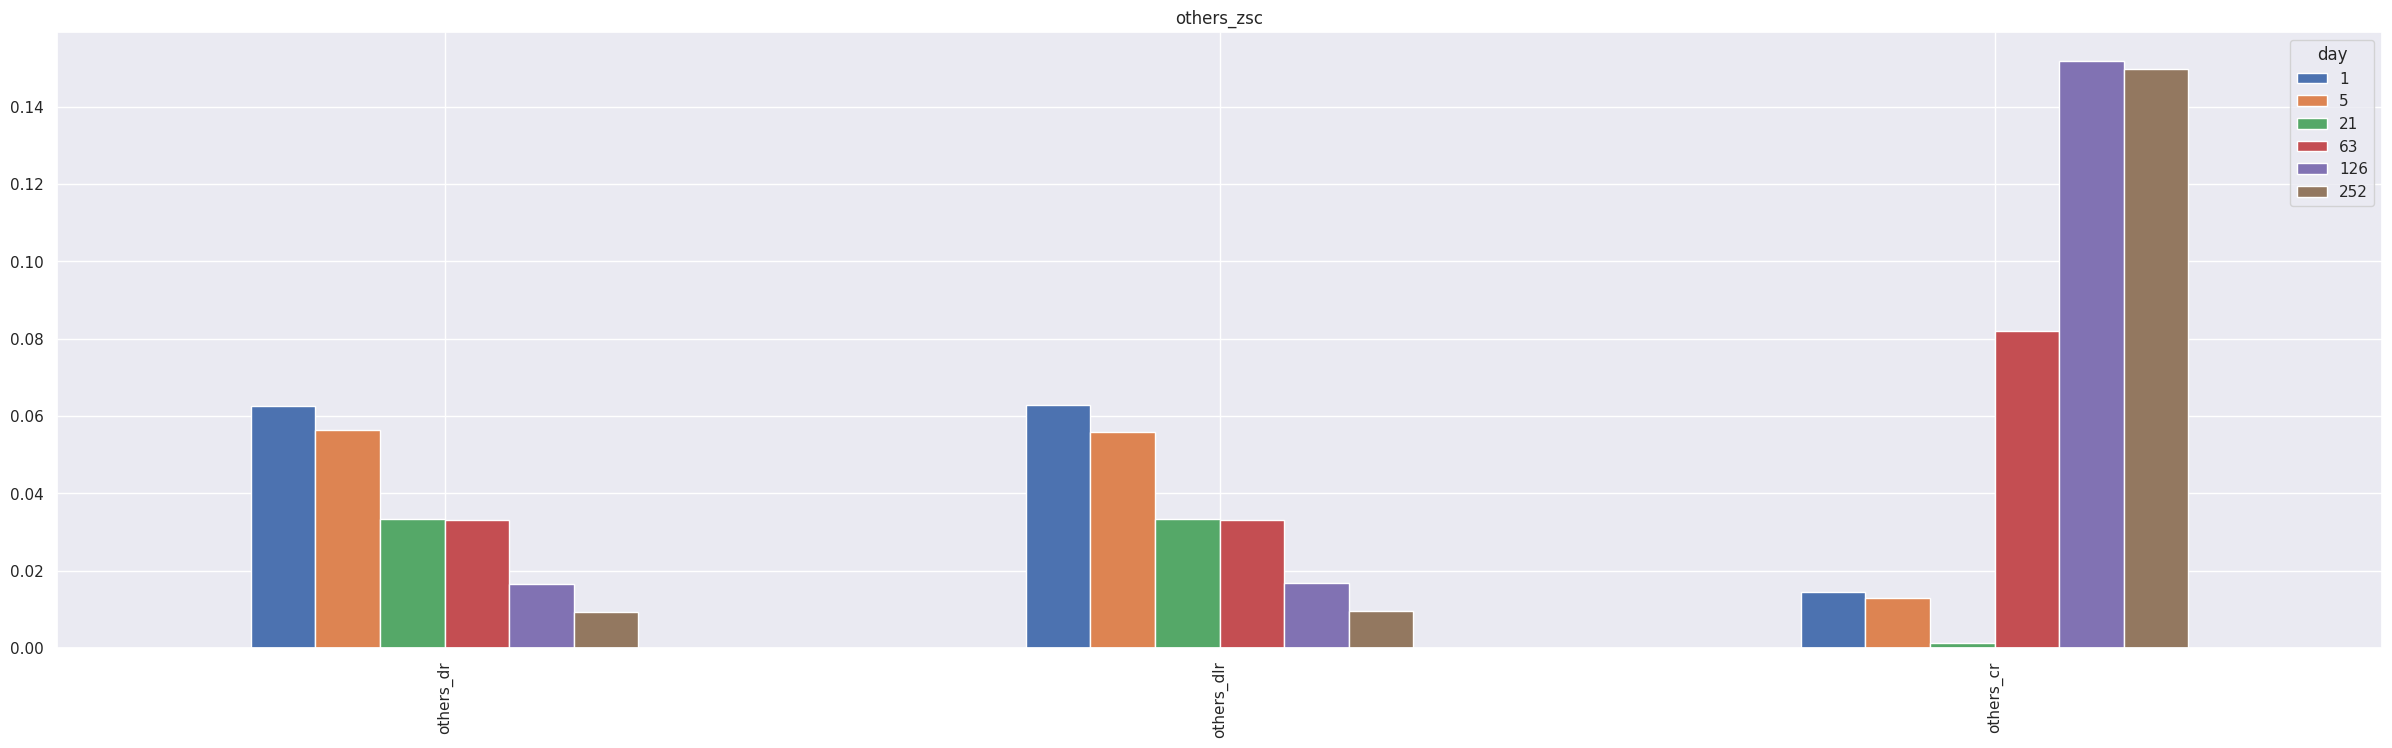

In [ ]:
days = pd.Series([1,5,21,63,126,252],name='day')
corr_day = pd.DataFrame(columns=days)

# lnprc.diff(day): Log return from previous {day} days
# lnret.shift(-day): Shift backwards to test predictability
for day in days:
  lnret = lnprc.diff(day)
  back_shifted = lnret.shift(-day)
  corr_day[day] = norm_ta.apply(lambda ta: ta.corr(back_shifted))

corr_day.abs().plot(kind='bar',title=f'{group_name}_{norm_method}')

<Axes: title={'center': 'corr_126_zsc'}>

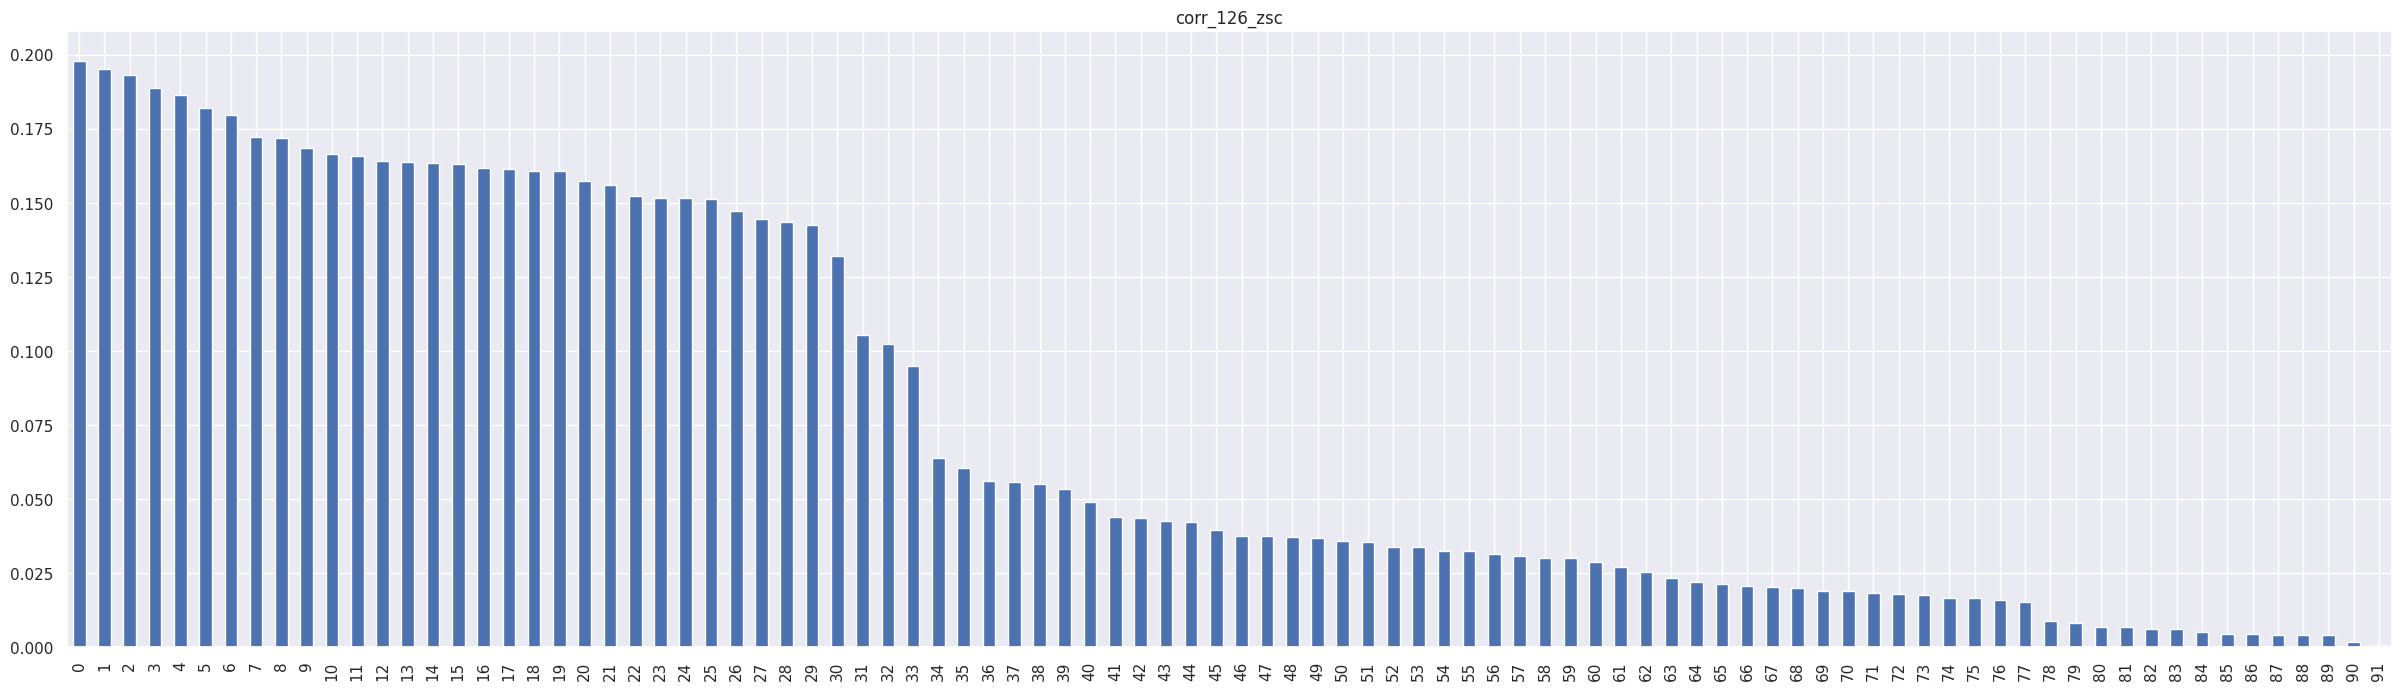

In [ ]:
day = 126
lnret = lnprc.diff(day)
back_shifted = lnret.shift(-day)

norm_method = 'zsc'
corr_data = norm_ta_data[norm_method].apply(lambda ta: ta.corr(back_shifted))

#corr_data.abs().sort_values(ascending=False).plot(kind='bar',title='corr_126_zsc')
corr_data.abs().sort_values(ascending=False).plot(kind='bar',title='corr_126_zsc',xticks=range(len(corr_data)))

In [ ]:
top_count = 30

top_ta_names = corr_data.abs().sort_values(ascending=False)[:top_count].index.to_list()
top_ta = norm_ta_data[norm_method][top_ta_names]
top_ta_direction = np.sign(corr_data)[top_ta_names]

## Profitability

### Indicator to forecast signals

In [ ]:
smooth_window = 126

smooth_ta = top_ta.rolling(window=smooth_window).mean()
forecast = smooth_ta.mul(top_ta_direction,axis=1)

#smooth_ta = norm_ta_data[norm_method].rolling(window=smooth_window).mean()
#forecast = smooth_ta.mul(np.sign(corr_data),axis=1)

forecast[forecast > 1] = 1
forecast[forecast < -1] = -1

### Forecast correlation matrix

Text(0.5, 1.0, 'top30forecast_corr')

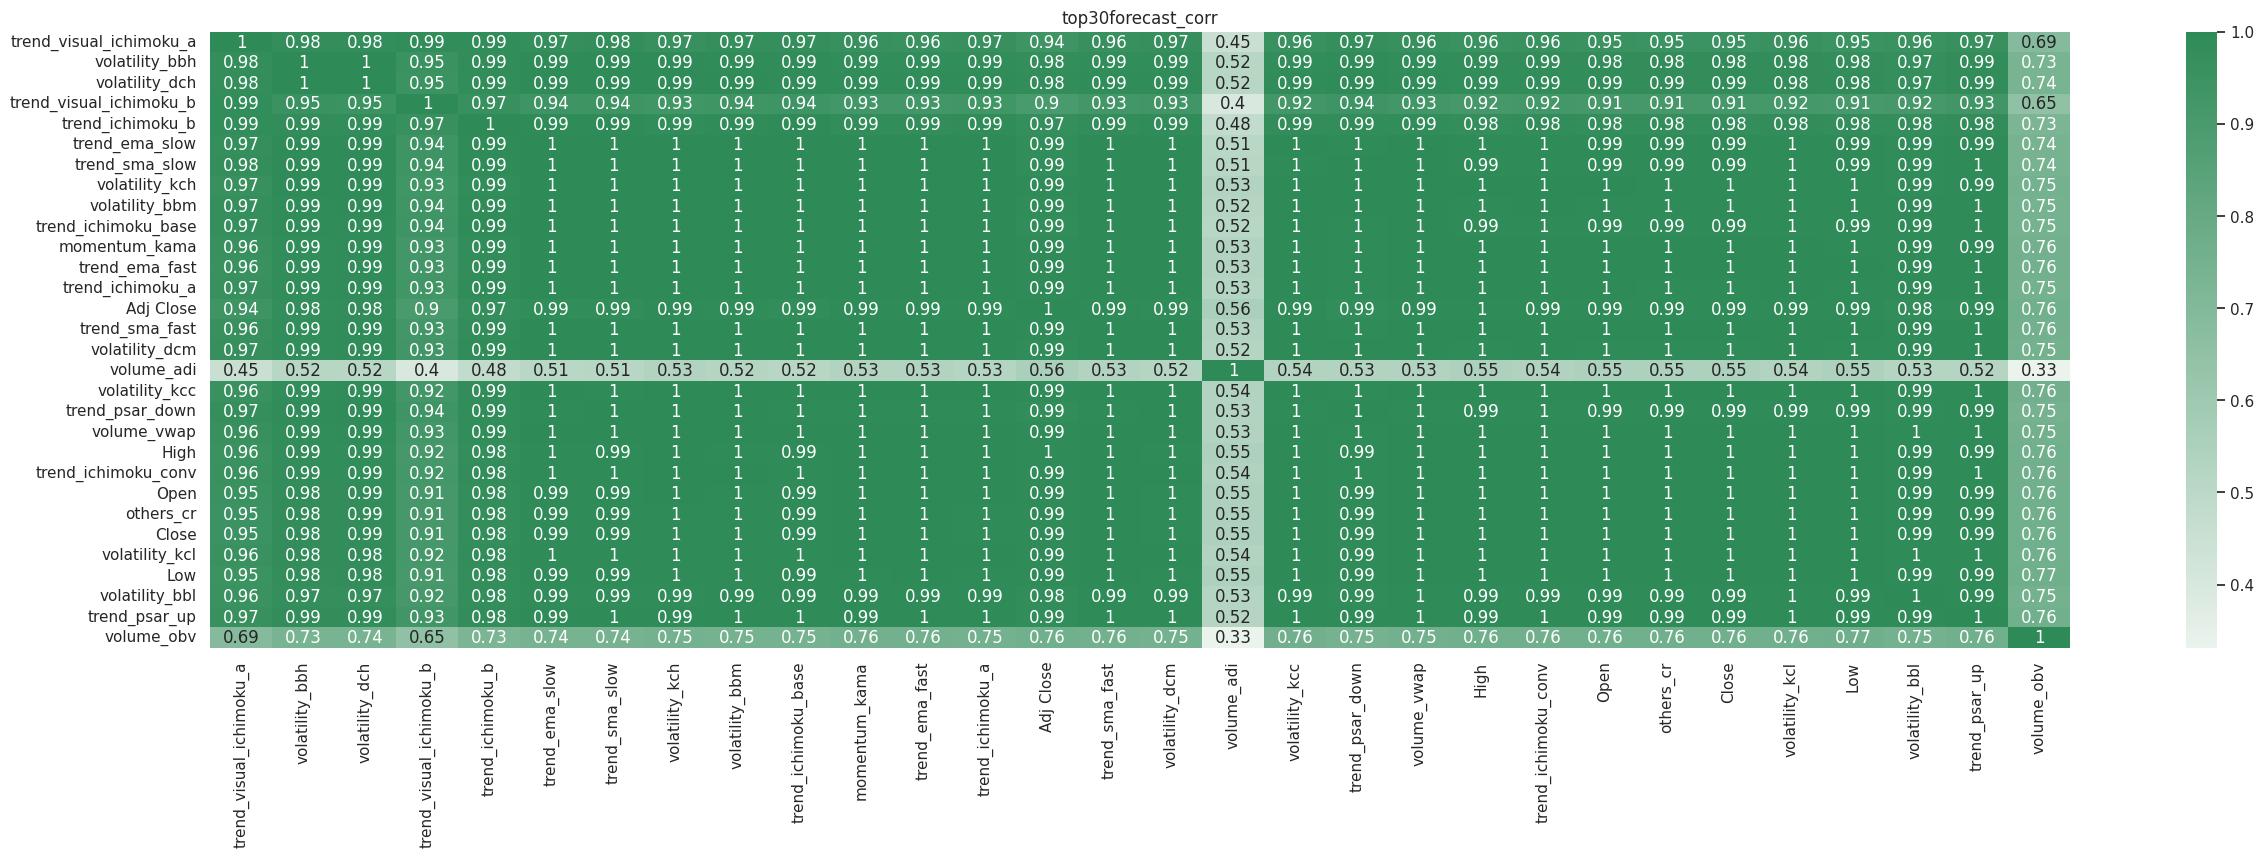

In [ ]:
sns.heatmap(forecast.corr(),annot=True,cmap=SNS_CMAP).set_title(f'top{top_count}forecast_corr')

### Evaluator

In [ ]:
class Evaluator():
  from datetime import datetime as dt
  from scipy.stats import t

  ff3_reader = pdr.famafrench.FamaFrenchReader('F-F_Research_Data_Factors_daily',start='1900-01-01',end=str(dt.today()))
  ff3 = ff3_reader.read()[0]/100
  ff3_reader.close()

  mom_reader = pdr.famafrench.FamaFrenchReader('F-F_Momentum_Factor_daily',start='1900-01-01',end=str(dt.today()))
  mom = mom_reader.read()[0]/100
  mom_reader.close()

  fourFactor = pd.concat([ff3,mom],axis=1)
  def __init__(self,returns):
    self.set_returns(returns)
    self.set_fourFactor()
  def set_fourFactor(self):
    self.fourFactor['Strategy-RF'] = self.returns - self.fourFactor['RF']
    self.fourFactor.dropna(inplace=True)
  def set_returns(self,returns):
    self.returns = returns.copy()
  def reset_summary(self):
    self.summary = pd.DataFrame()
  def get_summary(self):
    self.reset_summary()
    pd.set_option('display.float_format', lambda x: f'{x:.4f}')
    summary = pd.DataFrame()
    summary.loc['Cum Return',['Value','Sample size']] = self.get_cumRet()
    summary.loc['Mean',['Value','Sample size']] = self.get_mean()
    summary.loc['Vol',['Value','Sample size']] = self.get_vol()
    summary.loc['SR',['Value','Sample size','P-value']] = self.get_sharpeRatio()
    summary.loc['CAPM Alpha',['Value','Sample size','P-value']] = self.get_CAPMAlpha()
    summary.loc['Carhart Alpha',['Value','Sample size','P-value']] = self.get_CarhartAlpha()
    summary.loc['Beta',['Value','Sample size','P-value']] = self.get_beta()
    summary.loc['Skew',['Value','Sample size']] = self.get_skew()
    summary.loc['Skew (M)',['Value','Sample size']] = self.get_monthlySkew()
    summary.loc['Kurt',['Value','Sample size']] = self.get_kurt()
    summary.loc['Avg Drawdown',['Value','Sample size']] = self.get_avgDrawdown()
    summary.loc['Max Drawdown',['Value','Sample size']] = self.get_maxDrawdown()
    summary.loc['Kurt',['Value','Sample size']] = self.get_kurt()
    summary.loc['Downside Risk',['Value','Sample size']] = self.get_downsideRisk()
    summary.loc['VaR 95%',['Value','Sample size']] = self.get_VaR(0.95)
    summary.loc['Exp Shortfall 95%',['Value','Sample size']] = self.get_expectedShortfall(0.95)
    summary.loc['VaR 99%',['Value','Sample size']] = self.get_VaR(0.99)
    summary.loc['Exp Shortfall 99%',['Value','Sample size']] = self.get_expectedShortfall(0.99)
    self.summary = summary
    return self.summary
  def get_cumsum(self):
    cumsum = self.returns.cumsum()
    return cumsum
  def get_cumprod(self):
    cumprod = (1+self.returns).cumprod()
    return cumprod
  def get_cumRet(self):
    cumprod = self.get_cumprod()[-1]
    cumRet = cumprod-1
    sampleSize = cumprod.size
    return cumRet,sampleSize
  def get_CAPMAlpha(self):
    Y = self.fourFactor['Strategy-RF']
    X = sm.add_constant(self.fourFactor['Mkt-RF'])
    sampleSize = Y.size
    model = sm.OLS(Y,X)
    result = model.fit()
    alpha = result.params[0]*252
    p = result.pvalues[0]
    return alpha,sampleSize,p
  def get_beta(self):
    Y = self.fourFactor['Strategy-RF']
    X = sm.add_constant(self.fourFactor['Mkt-RF'])
    sampleSize = Y.size
    model = sm.OLS(Y,X)
    result = model.fit()
    beta = result.params[1]
    p = result.pvalues[1]
    return beta,sampleSize,p
  def get_CarhartAlpha(self):
    Y = self.fourFactor['Strategy-RF']
    X = sm.add_constant(self.fourFactor[['Mkt-RF','SMB','HML','Mom   ']])
    sampleSize = Y.size
    model = sm.OLS(Y,X)
    result = model.fit()
    alpha = result.params[0]*252
    p = result.pvalues[0]
    return alpha,sampleSize,p
  def get_CAPMSummary(self):
    Y = self.fourFactor['Strategy-RF']
    X = sm.add_constant(self.fourFactor['Mkt-RF'])
    model = sm.OLS(Y,X)
    result = model.fit()
    return result.summary()
  def get_CarhartSummary(self):
    Y = self.fourFactor['Strategy-RF']
    X = sm.add_constant(self.fourFactor[['Mkt-RF','SMB','HML','Mom   ']])
    model = sm.OLS(Y,X)
    result = model.fit()
    return result.summary()
  def get_factorCorr(self):
    return self.fourFactor.corr()
  def get_mean(self):
    mean = self.returns.mean()*252
    sampleSize = self.returns.size
    return mean,sampleSize
  def get_vol(self):
    vol = self.returns.std()*np.sqrt(252)
    sampleSize = self.returns.size
    return vol,sampleSize
  def get_sharpeRatio(self):
    sharpeRatio = self.fourFactor['Strategy-RF'].mean()/self.fourFactor['Strategy-RF'].std()*np.sqrt(252)
    sampleSize = self.returns.size

    t_stat = sharpeRatio * np.sqrt(sampleSize)
    # p-value for 2-sided test
    p_2sided = 2*(1 - Evaluator.t.cdf(abs(t_stat), sampleSize))

    return sharpeRatio,sampleSize,p_2sided
  def get_monthlyReturns(self):
    monthlyReturns = (1+self.returns).resample('M').prod()-1
    return monthlyReturns
  def get_monthlySkew(self):
    monthlyReturns = self.get_monthlyReturns()
    monthlySkew = monthlyReturns.skew()
    sampleSize = monthlyReturns.size
    return monthlySkew,sampleSize
  def get_skew(self):
    skew = self.returns.skew()
    sampleSize = self.returns.size
    return skew,sampleSize
  def get_kurt(self):
    kurt = self.returns.kurt()
    sampleSize = self.returns.size
    return kurt,sampleSize
  def get_downsideRisk(self,requiredReturn=0):
    downside = requiredReturn-self.returns
    downside[downside>0] = 0
    downsideRisk = np.sqrt((downside**2).mean())*np.sqrt(252)
    sampleSize = downside[downside<0].size
    return downsideRisk,sampleSize
  def get_VaR(self,confidence=0.99):
    VaR = self.returns.quantile(q=(1-confidence))
    sampleSize = self.returns.size
    return VaR,sampleSize
  def get_expectedShortfall(self,confidence=0.99):
    VaR = self.get_VaR(confidence)[0]
    shortfall = self.returns[self.returns<VaR]
    expectedShortfall = shortfall.mean()
    sampleSize = shortfall.size
    return expectedShortfall,sampleSize
  def get_drawdowns(self):
    cumprod = self.get_cumprod()
    drawdowns = cumprod/cumprod.expanding().max() - 1
    drawdowns = drawdowns[drawdowns<0]
    return drawdowns
  def get_maxDrawdown(self):
    maxDrawdown = self.get_drawdowns().min()
    sampleSize = 1
    return maxDrawdown,sampleSize
  def get_avgDrawdown(self):
    drawdowns = self.get_drawdowns()
    avgDrawdown = drawdowns.mean()
    sampleSize = drawdowns.size
    return avgDrawdown,sampleSize

### Evaluation

#### Scale-in Long-Short

In [ ]:
lnret = lnprc.diff(1)

position = forecast.shift(1)

pnl = position.mul(lnret,axis=0)

df = pd.DataFrame()
df['SR'] = pnl.apply(lambda ret: Evaluator(ret).get_sharpeRatio()[0])
df['ADD'] = pnl.apply(lambda ret: Evaluator(ret).get_avgDrawdown()[0])
df['Mean'] = pnl.apply(lambda ret: Evaluator(ret).get_mean()[0])
df['Vol'] = pnl.apply(lambda ret: Evaluator(ret).get_vol()[0])
df.sort_values('SR',ascending=False)[:30]

,SR,ADD,Mean,Vol
Adj Close,0.3602,-0.0925,0.0727,0.1365
volatility_bbh,0.3417,-0.1020,0.0727,0.1438
volatility_dch,0.3407,-0.1053,0.0734,0.1466
trend_visual_ichimoku_a,0.3342,-0.1053,0.0709,0.1418
trend_ema_slow,0.3230,-0.1069,0.0707,0.1460
volatility_kch,0.3224,-0.1037,0.0690,0.1411
trend_sma_slow,0.3207,-0.1049,0.0695,0.1435
High,0.3191,-0.1001,0.0671,0.1366
trend_ema_fast,0.3175,-0.1020,0.0680,0.1402
Open,0.3175,-0.0977,0.0663,0.1348


#### Half-in Long-Short

In [ ]:
lnret = lnprc.diff(1)

round_forecast = np.around(forecast)
position = round_forecast.shift(1)

pnl = position.mul(lnret,axis=0)

df = pd.DataFrame()
df['SR'] = pnl.apply(lambda ret: Evaluator(ret).get_sharpeRatio()[0])
df['ADD'] = pnl.apply(lambda ret: Evaluator(ret).get_avgDrawdown()[0])
df['Mean'] = pnl.apply(lambda ret: Evaluator(ret).get_mean()[0])
df['Vol'] = pnl.apply(lambda ret: Evaluator(ret).get_vol()[0])
df.sort_values('SR',ascending=False)[:30]

,SR,ADD,Mean,Vol
High,0.4066,-0.1055,0.0937,0.1716
Open,0.4033,-0.1033,0.0929,0.1711
trend_ema_fast,0.3907,-0.1130,0.0914,0.1727
others_cr,0.3903,-0.1062,0.0905,0.1705
Close,0.3903,-0.1062,0.0905,0.1705
volatility_kcc,0.3891,-0.1091,0.0908,0.1718
trend_sma_slow,0.3849,-0.1188,0.0909,0.1740
Adj Close,0.3836,-0.1122,0.0898,0.1716
trend_ema_slow,0.3802,-0.1236,0.0902,0.1744
volatility_kch,0.3767,-0.1214,0.0894,0.1737


#### All-in Long-Short

In [ ]:
lnret = lnprc.diff(1)

allin_forecast = np.sign(forecast)
position = allin_forecast.shift(1)

pnl = position.mul(lnret,axis=0)

df = pd.DataFrame()
df['SR'] = pnl.apply(lambda ret: Evaluator(ret).get_sharpeRatio()[0])
df['ADD'] = pnl.apply(lambda ret: Evaluator(ret).get_avgDrawdown()[0])
df['Mean'] = pnl.apply(lambda ret: Evaluator(ret).get_mean()[0])
df['Vol'] = pnl.apply(lambda ret: Evaluator(ret).get_vol()[0])
df.sort_values('SR',ascending=False)[:60]

,SR,ADD,Mean,Vol
trend_psar_up,0.466803,-0.111786,0.113219,0.191186
Adj Close,0.443863,-0.115542,0.108849,0.191196
trend_ichimoku_conv,0.434439,-0.111676,0.107055,0.191200
volatility_dch,0.418974,-0.123655,0.104109,0.191206
High,0.418802,-0.113384,0.104077,0.191206
volatility_kcl,0.417919,-0.121193,0.103908,0.191207
volatility_bbl,0.414385,-0.110377,0.103235,0.191208
Close,0.414361,-0.119027,0.103231,0.191208
others_cr,0.414361,-0.119027,0.103231,0.191208
volume_vwap,0.411204,-0.128036,0.102627,0.191209


Text(0.5, 1.0, 'pnl_corr')

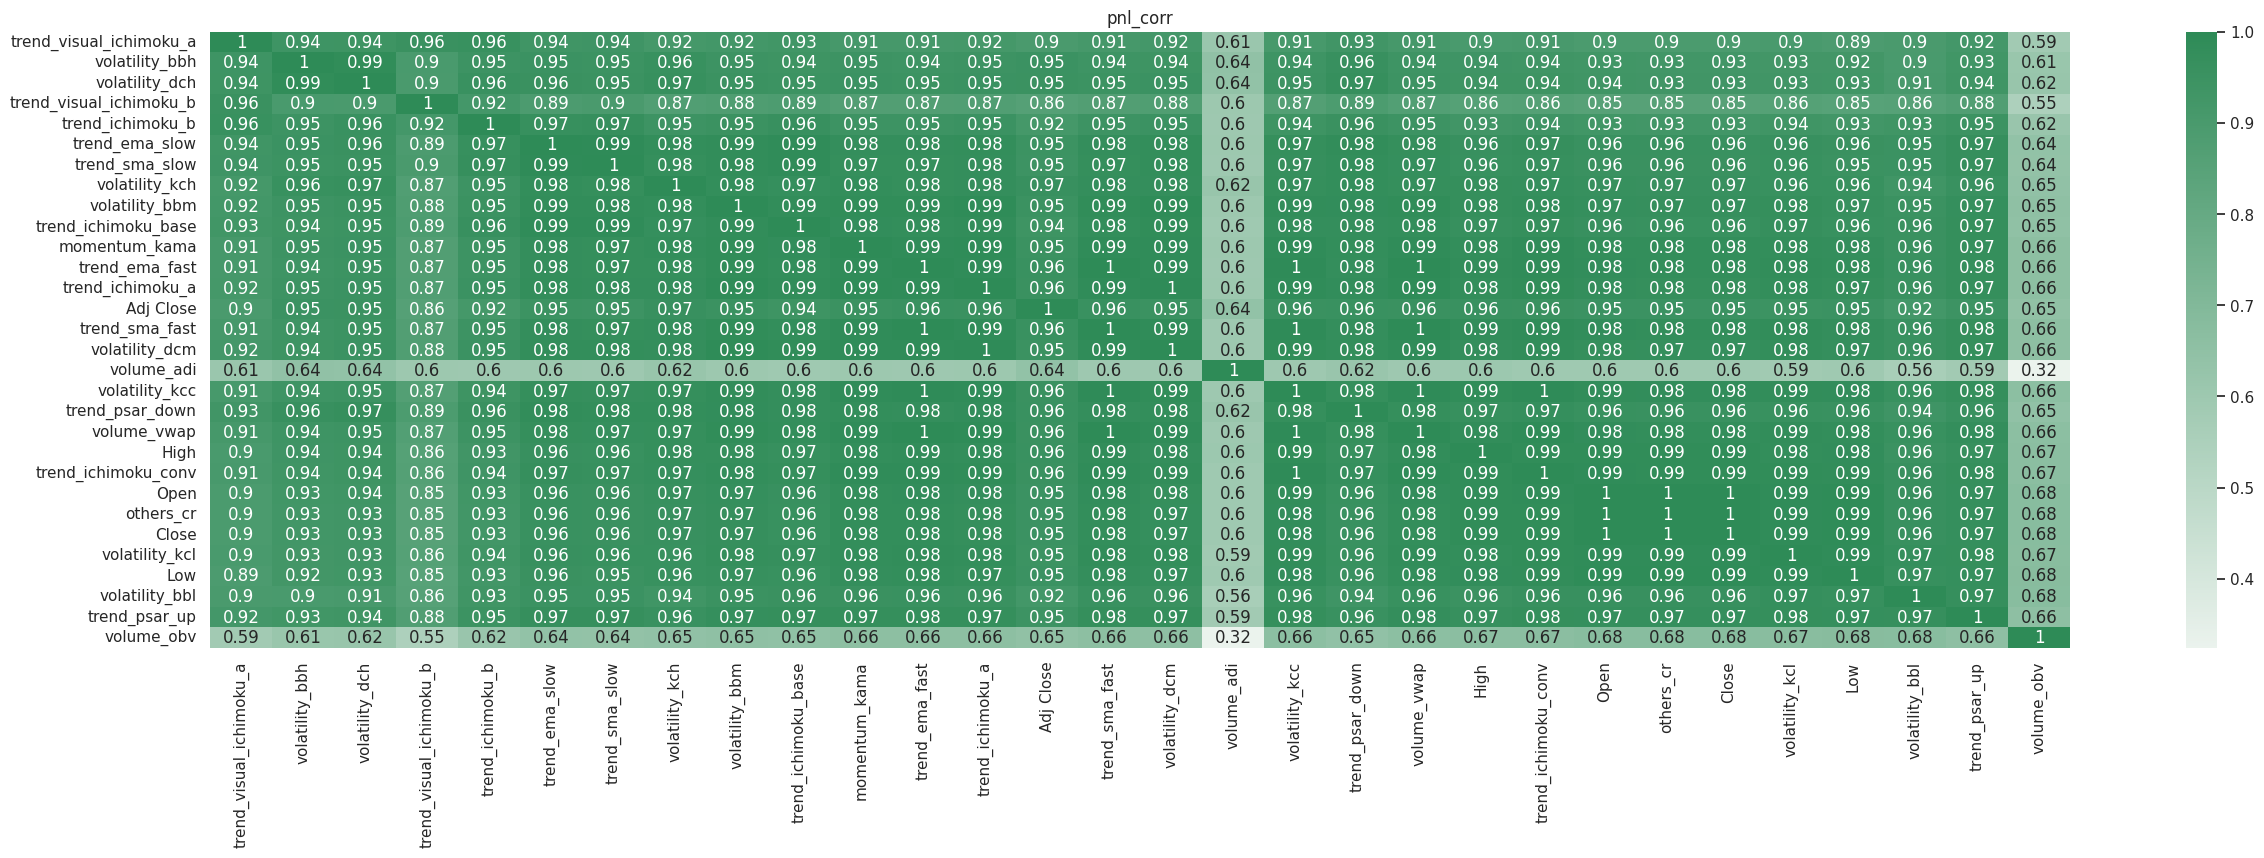

In [ ]:
sns.heatmap(pnl.corr(),annot=True,cmap=SNS_CMAP).set_title('pnl_corr')

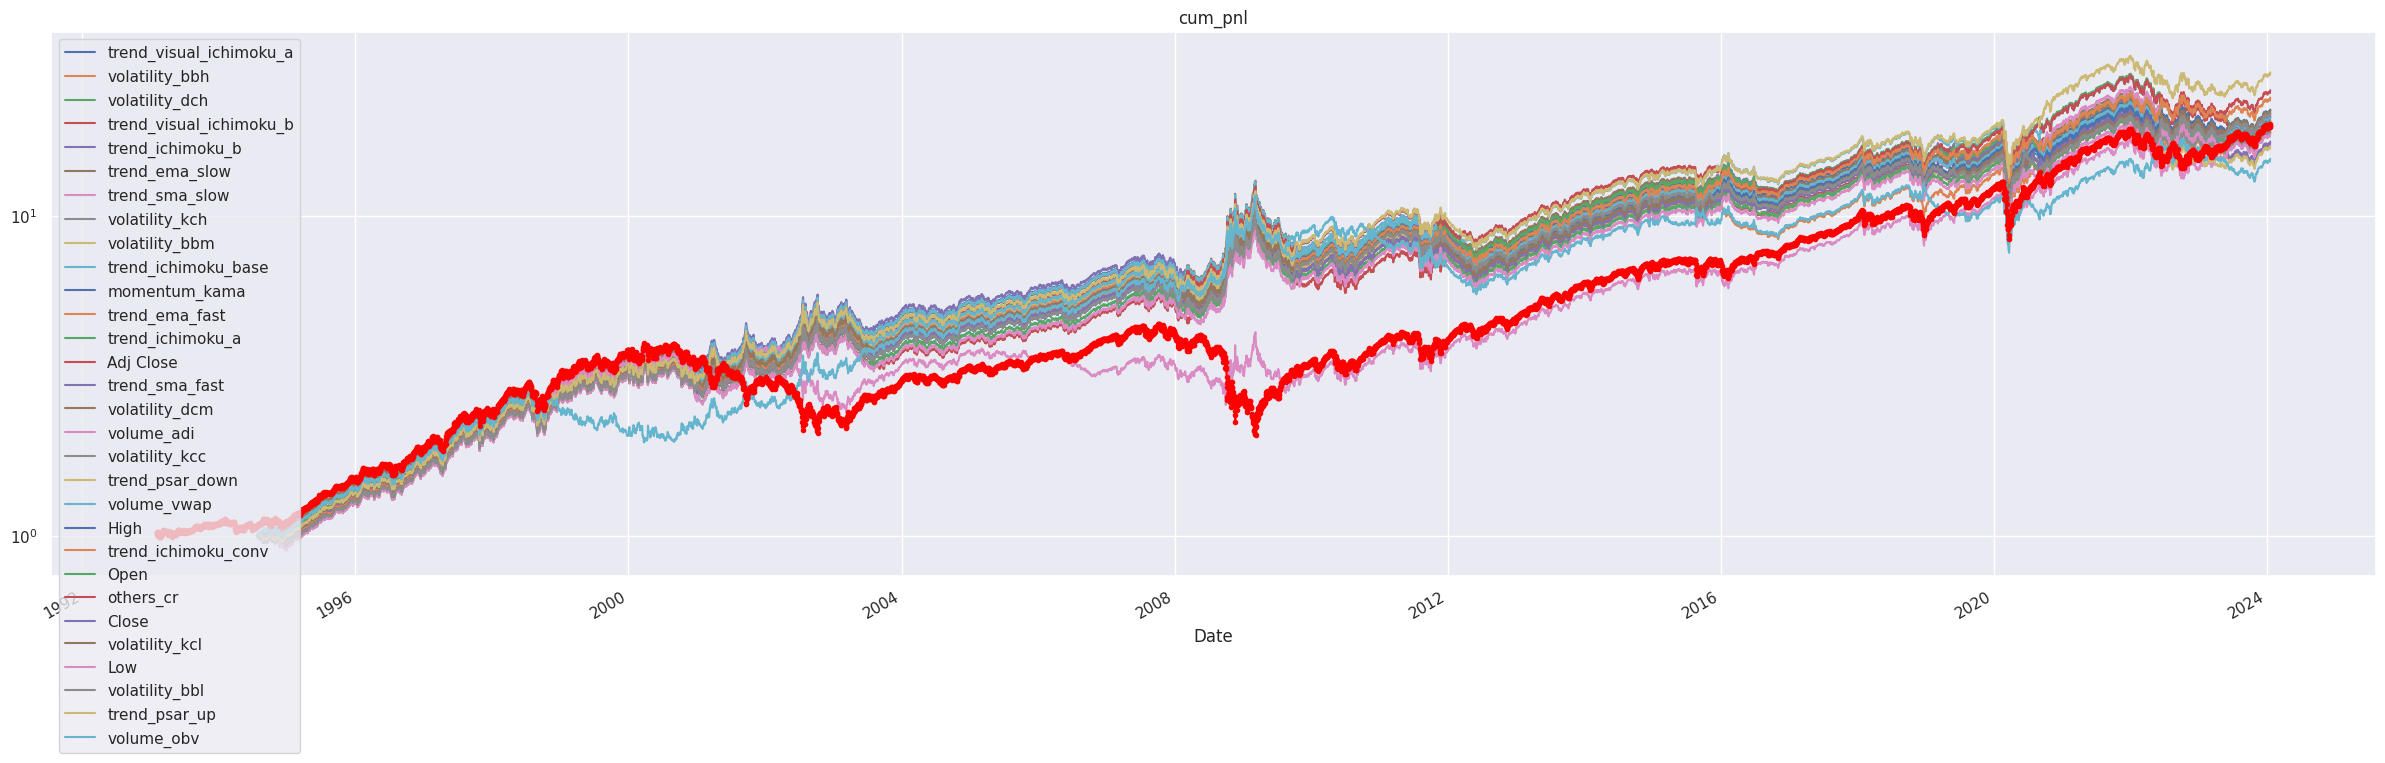

In [ ]:
ax = np.exp(pnl.cumsum()).plot()
np.exp(lnret.cumsum()).plot(color='red',linestyle='-.',marker='.',ax=ax)
ax.set_title('cum_pnl')
ax.set_yscale('log')

## Combined strategy

In [ ]:
lnret = lnprc.diff(1)

allin_forecast = np.sign(forecast)

vote_forecast = allin_forecast.mean(axis=1)
vote_forecast[vote_forecast>=0.9] = 1
vote_forecast[(vote_forecast>-0.9)&(vote_forecast<0.9)] = 0
vote_forecast[vote_forecast<=-0.9] = -1

position = vote_forecast.shift(1)

pnl = position.mul(lnret,axis=0)

Evaluator(pnl).get_summary()

,Value,Sample size,P-value
Cum Return,14.5249,1.0000,NaN
Mean,0.1099,7799.0000,NaN
Vol,0.1826,7799.0000,NaN
SR,0.4703,7799.0000,0.0000
CAPM Alpha,0.0683,7389.0000,0.0393
Carhart Alpha,0.0368,7389.0000,0.2230
Beta,0.1897,7389.0000,0.0000
Skew,-0.4102,7799.0000,NaN
Skew (M),-0.1691,373.0000,NaN
Kurt,12.9747,7799.0000,NaN


## Multiple regression model

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

data = list(zip(x, y))
knn = KNeighborsClassifier(n_neighbors=1)

knn.fit(data, classes) 

In [ ]:

symbols = ['GLD','TLT','UUP']
ctrl_prc = yf.download(symbols)
ctrl_prc.dropna(inplace=True)
ctrl_lnret = np.log(ctrl_prc['Adj Close']).diff()

lnret = lnprc.diff(1)

allin_forecast = np.sign(forecast)

vote_forecast = allin_forecast.mean(axis=1)
vote_forecast[vote_forecast>=0.9] = 1
vote_forecast[(vote_forecast>-0.9)&(vote_forecast<0.9)] = 0
vote_forecast[vote_forecast<=-0.9] = -1

[*********************100%%**********************]  3 of 3 completed


In [ ]:
reg_df = ctrl_lnret.shift(1)
reg_df['Vol'] = lnprc.diff(1).rolling(30).std()
reg_df['Forecast'] = vote_forecast.shift(1)
reg_df['Ret'] = lnprc.diff(1)
reg_df.dropna(inplace=True)

reg_df = reg_df.iloc[:252*10]

y = reg_df['Ret']
X = reg_df.iloc[:,:-1]
model = sm.OLS(y,X)
result = model.fit()

In [ ]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    Ret   R-squared (uncentered):                   0.005
Model:                            OLS   Adj. R-squared (uncentered):              0.003
Method:                 Least Squares   F-statistic:                              2.363
Date:                Sun, 21 Jan 2024   Prob (F-statistic):                      0.0377
Time:                        15:30:11   Log-Likelihood:                          7356.6
No. Observations:                2520   AIC:                                 -1.470e+04
Df Residuals:                    2515   BIC:                                 -1.467e+04
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
GLD           -0.0686      0.023     -2.952      0.003      -0.114      -0.023
TLT            0.0400      0.028      1.454      0.146      -0.014       0.094
UUP           -0.0413      0.050     -0.825      0.409      -0.139       0.057
Vol            0.0024      0.020      0.119      0.905      -0.037       0.042
Forecast       0.0004      0.000      1.269      0.204      -0.000       0.001
==============================================================================
Omnibus:                      512.055   Durbin-Watson:                   2.138
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16661.711
Skew:                          -0.082   Prob(JB):                         0.00
Kurtosis:                      15.596   Cond. No.                         185.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:

position = vote_forecast.shift(1)

pnl = position.mul(lnret,axis=0)

Evaluator(pnl).get_summary()

# Testing on multiple assets

In [ ]:
symbols = ['SPY','GLD','TLT']
days = [126,252,63]
top_counts = [30,60,5]
pnl = pd.DataFrame()
stats = pd.DataFrame()

for symbol,day,top_count in zip(symbols,days,top_counts):

  # Prepare data
  prc = yf.download(symbol)
  prc.dropna(inplace=True)
  lnprc = np.log(prc['Adj Close'])
  prc_ta = add_all_ta_features(prc,
                            open="Open",
                            high="High",
                            low="Low",
                            close="Close",
                            volume="Volume",
                            fillna=True)

  # Normalize TA indicators
  ta_data = prc_ta
  window = 252

  norm_ta_data = dict()
  norm_ta_data['raw'] = ta_data
  norm_ta_data['pct'] = Norm.percentile_ts(ta_data,window)
  norm_ta_data['zsc'] = Norm.zscore_ts(ta_data,window)
  norm_ta_data['ams'] = Norm.absmeanscaled_ts(ta_data,window)

  #day = 252
  lnret = lnprc.diff(day)
  back_shifted = lnret.shift(-day)

  norm_method = 'zsc'
  corr_data = norm_ta_data[norm_method].apply(lambda ta: ta.corr(back_shifted))

  #top_count = 30

  top_ta_names = corr_data.abs().sort_values(ascending=False)[:top_count].index.to_list()
  top_ta = norm_ta_data[norm_method][top_ta_names]
  top_ta_direction = np.sign(corr_data)[top_ta_names]

  top_ta = norm_ta_data[norm_method][top_ta_names]
  top_ta_direction = np.sign(corr_data)[top_ta_names]
  print(top_ta_names)

  # Indicators to forecast
  smooth_window = day

  smooth_ta = top_ta.rolling(window=smooth_window).mean()
  forecast = smooth_ta.mul(top_ta_direction,axis=1)

  forecast[forecast > 1] = 1
  forecast[forecast < -1] = -1

  # Calculate return
  lnret = lnprc.diff(1)

  allin_forecast = np.sign(forecast)

  vote_forecast = allin_forecast.mean(axis=1)
  vote_forecast[vote_forecast>=0.9] = 1
  vote_forecast[(vote_forecast>-0.9)&(vote_forecast<0.9)] = 0
  vote_forecast[vote_forecast<=-0.9] = -1

  position = vote_forecast.shift(1)

  pnl[symbol] = position.mul(lnret,axis=0)
  stats[symbol] = Evaluator(pnl[symbol]).get_summary()['Value']

[*********************100%%**********************]  1 of 1 completed


['trend_visual_ichimoku_a', 'volatility_bbh', 'volatility_dch', 'trend_visual_ichimoku_b', 'trend_ichimoku_b', 'trend_ema_slow', 'trend_sma_slow', 'volatility_kch', 'volatility_bbm', 'trend_ichimoku_base', 'momentum_kama', 'trend_ema_fast', 'trend_ichimoku_a', 'Adj Close', 'trend_sma_fast', 'volatility_dcm', 'volume_adi', 'volatility_kcc', 'trend_psar_down', 'volume_vwap', 'High', 'trend_ichimoku_conv', 'Open', 'others_cr', 'Close', 'volatility_kcl', 'Low', 'volatility_bbl', 'trend_psar_up', 'volume_obv']


[*********************100%%**********************]  1 of 1 completed


['trend_visual_ichimoku_b', 'trend_ichimoku_b', 'trend_ema_slow', 'volatility_bbh', 'trend_visual_ichimoku_a', 'trend_sma_slow', 'trend_psar_down', 'volatility_dch', 'volatility_bbm', 'momentum_kama', 'volatility_kch', 'trend_ichimoku_base', 'trend_ema_fast', 'trend_sma_fast', 'trend_ichimoku_a', 'volatility_dcm', 'volatility_kcc', 'volume_vwap', 'trend_ichimoku_conv', 'High', 'volatility_kcl', 'Open', 'others_cr', 'Adj Close', 'Close', 'trend_psar_up', 'volatility_bbl', 'Low', 'volume_obv', 'trend_adx_pos', 'volatility_dcl', 'momentum_pvo_signal', 'momentum_ppo_signal', 'trend_kst', 'trend_trix', 'momentum_ppo', 'trend_macd_signal', 'volume_vpt', 'trend_macd', 'trend_kst_sig', 'trend_mass_index', 'volume_sma_em', 'volume_fi', 'momentum_ao', 'momentum_pvo', 'volatility_atr', 'trend_vortex_ind_neg', 'volume_nvi', 'volatility_kcw', 'momentum_roc', 'momentum_tsi', 'trend_vortex_ind_diff', 'trend_kst_diff', 'volume_cmf', 'trend_aroon_down', 'trend_dpo', 'volatility_ui', 'trend_macd_diff', 

[*********************100%%**********************]  1 of 1 completed


['volume_nvi', 'volume_vpt', 'trend_visual_ichimoku_b', 'volume_cmf', 'trend_visual_ichimoku_a']


[*********************100%%**********************]  1 of 1 completed


<Axes: xlabel='Date'>

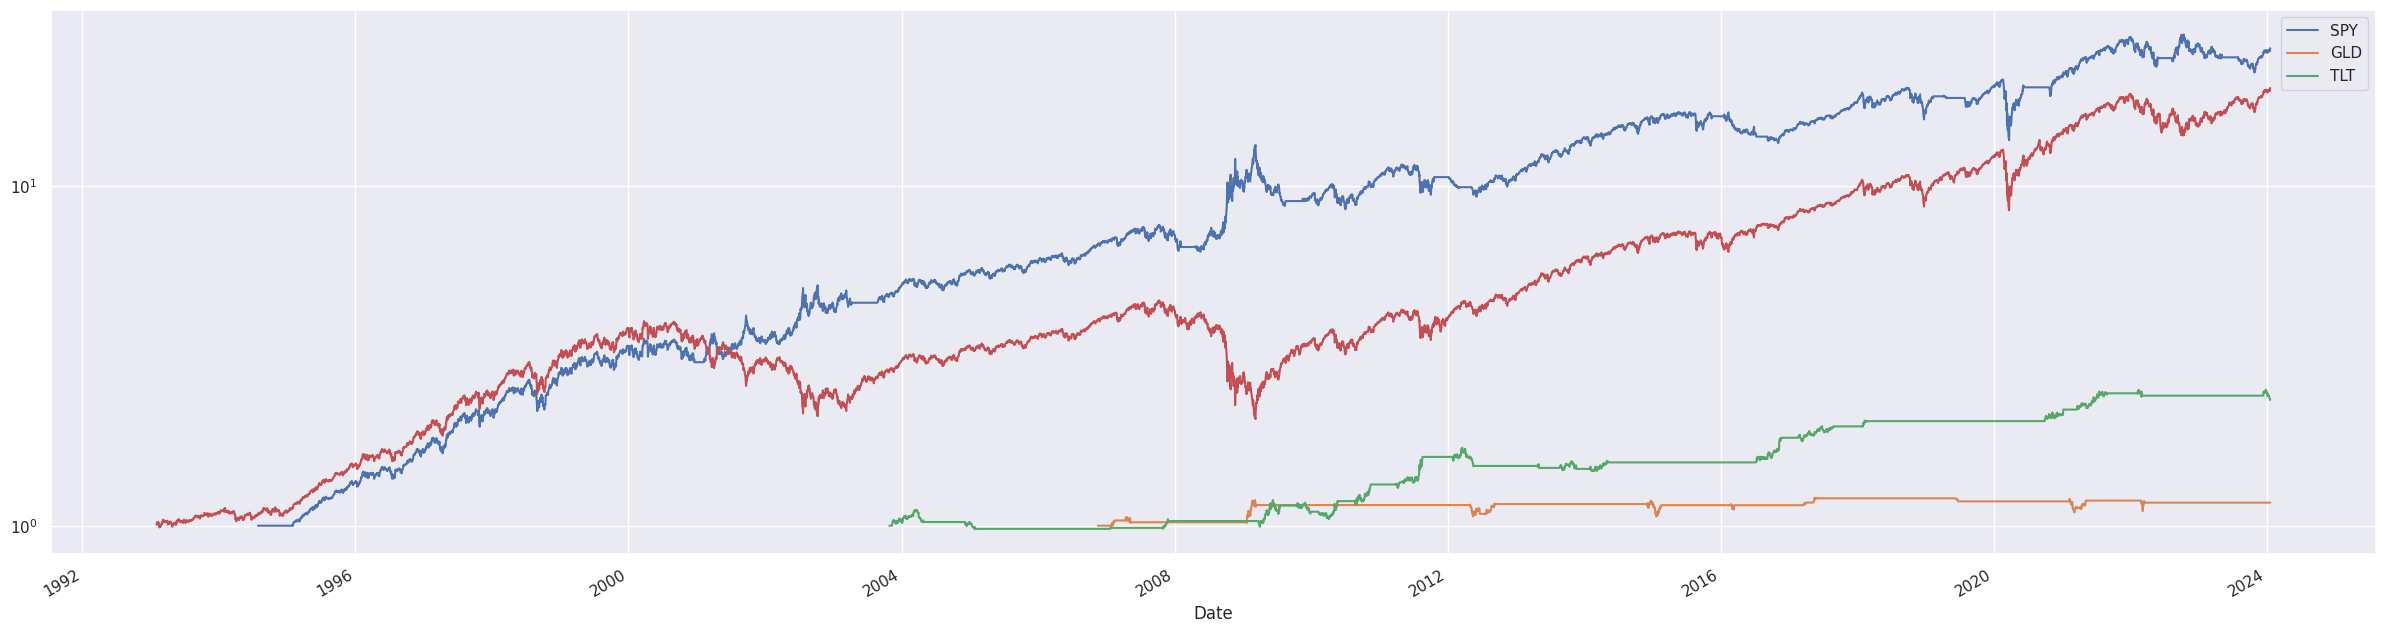

In [ ]:
ax = np.exp(pnl.cumsum()).plot()
ax.set_yscale('log')


prc = yf.download('SPY')
prc.dropna(inplace=True)
lnprc = np.log(prc['Adj Close'])

np.exp(lnprc.diff().cumsum()).plot(ax=ax)

#### test

<Axes: >

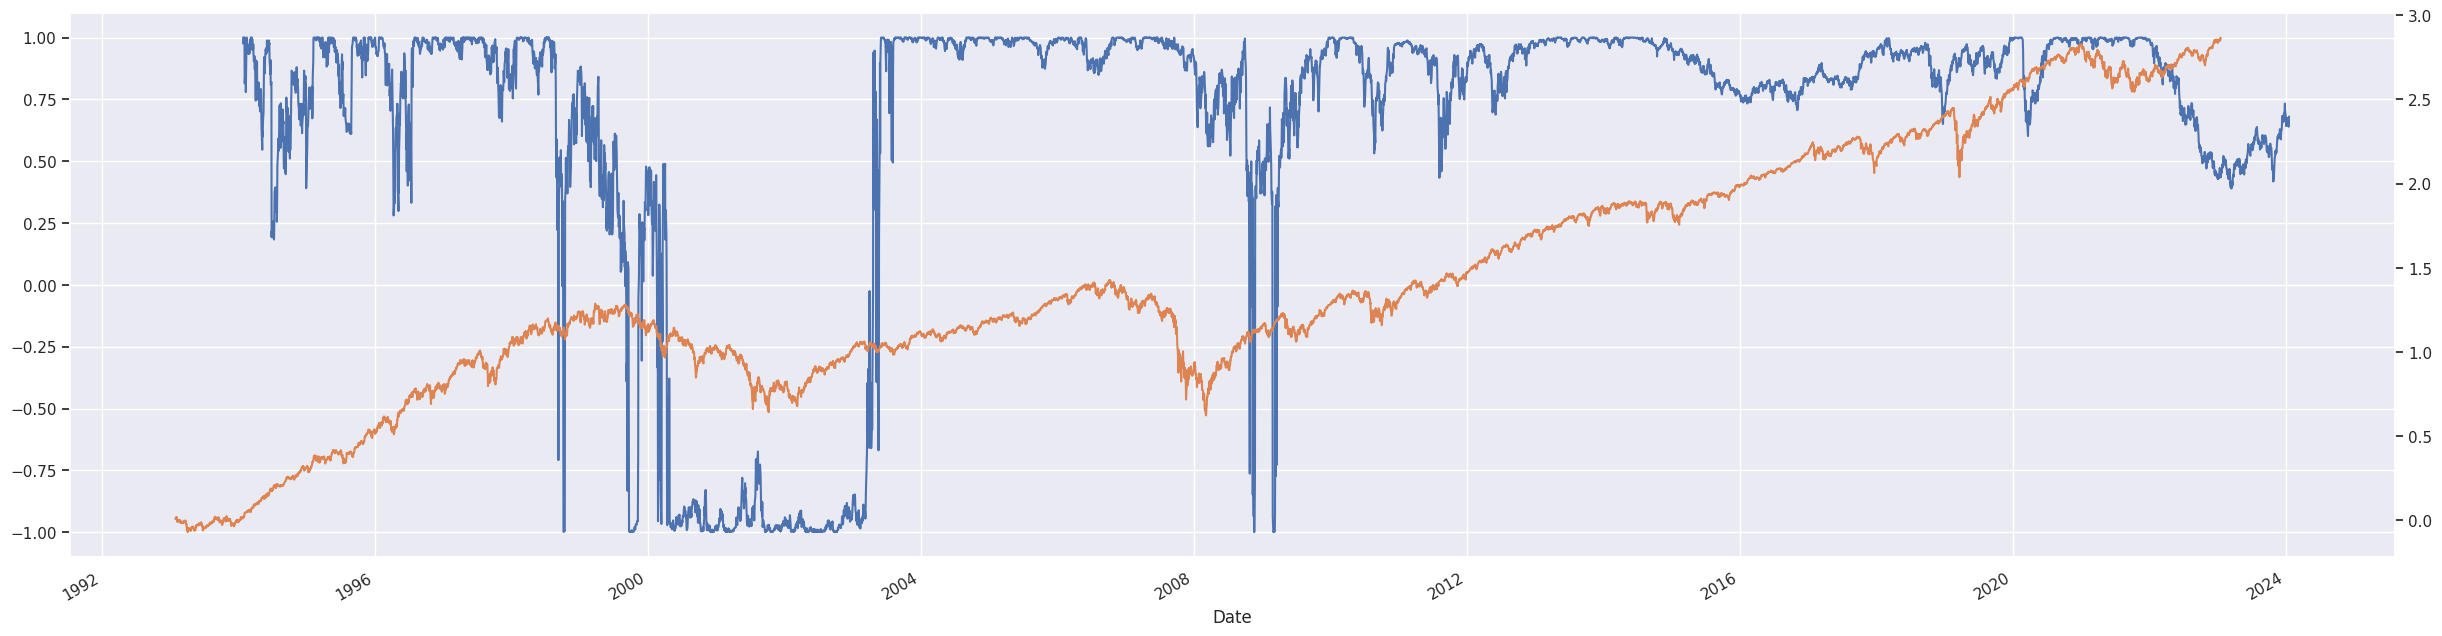

In [ ]:
day = 252
lnret = lnprc.diff(1)
back_shifted = lnret.shift(-day)

norm_ta['volume_obv'].plot()
back_shifted.cumsum().plot(secondary_y=True)

In [ ]:
for style,indicators in ta_groups.items():
  print(style,':')
  print(indicators)
  for

volume :
{'mfi', 'cmf', 'sma', 'vwap', 'obv', 'nvi', 'adi', 'vpt', 'em', 'fi'}
volatility :
{'bbm', 'bbp', 'kcl', 'dch', 'dcp', 'atr', 'bbhi', 'dcw', 'kcp', 'kcli', 'kch', 'dcm', 'dcl', 'kchi', 'kcc', 'ui', 'bbh', 'bbw', 'bbli', 'bbl', 'kcw'}
trend :
{'trix', 'cci', 'visual', 'ichimoku', 'psar', 'vortex', 'adx', 'sma', 'ema', 'dpo', 'stc', 'kst', 'aroon', 'macd', 'mass'}
momentum :
{'uo', 'pvo', 'tsi', 'roc', 'stoch', 'wr', 'kama', 'ppo', 'ao', 'rsi'}
others :
{'dlr', 'dr', 'cr'}


In [ ]:
spy_ta_ret = ls_decile_spy_ta.shift(1).mul(spy_lnret,axis=0).ffill().dropna()

In [ ]:
spy_ta_ret = decile_spy_ta.shift(1).mul(spy_lnret,axis=0).ffill().dropna()

In [ ]:
pre_sr = spy_ta_ret.mean()/spy_ta_ret.std()*np.sqrt(252)
direction = np.sign(pre_sr)

spy_ta_ret_adj = spy_ta_ret*direction

post_sr = spy_ta_ret_adj.mean()/spy_ta_ret.std()*np.sqrt(252)

In [ ]:
vanilla_ret = spy_ta_ret_adj[['Open','High','Low','Close','Adj Close','Volume']]

volume_ret = spy_ta_ret_adj[list(filter(lambda name: match('volume_*', name), ta_names))]
volatility_ret = spy_ta_ret_adj[list(filter(lambda name: match('volatility_*', name), ta_names))]
trend_ret = spy_ta_ret_adj[list(filter(lambda name: match('trend_*', name), ta_names))]
momentum_ret = spy_ta_ret_adj[list(filter(lambda name: match('momentum_*', name), ta_names))]
others_ret = spy_ta_ret_adj[list(filter(lambda name: match('others_*', name), ta_names))]

styles_ret = [volume_ret, volatility_ret, trend_ret, momentum_ret, others_ret]

In [ ]:
shrlist_styles_ret = list()
shrlist_styles = list()
for style in styles_ret:
  sr = (style.mean()/style.std()*np.sqrt(252))
  top_styles = sr.sort_values(ascending=False)[:5].index.to_list()


  shrlist_styles_ret.append(style[top_styles])
  shrlist_styles = shrlist_styles + top_styles
  print(f'Max: {sr.max():.2f} Med: {sr.median():.2f} Min: {sr.min():.2f}')
  print(top_styles)

Max: 0.41 Med: 0.12 Min: 0.02
['volume_cmf', 'volume_mfi', 'volume_em', 'volume_obv', 'volume_vwap']
Max: 0.75 Med: 0.13 Min: 0.04
['volatility_dcp', 'volatility_kcp', 'volatility_bbli', 'volatility_dch', 'volatility_kcc']
Max: 0.44 Med: 0.18 Min: 0.01
['trend_stc', 'trend_kst_sig', 'trend_vortex_ind_neg', 'trend_vortex_ind_diff', 'trend_adx_pos']
Max: 0.82 Med: 0.31 Min: 0.05
['momentum_uo', 'momentum_stoch', 'momentum_wr', 'momentum_rsi', 'momentum_stoch_rsi_d']
Max: 0.34 Med: 0.34 Min: 0.10
['others_dr', 'others_dlr', 'others_cr']


In [ ]:
reg = decile_spy_ta.ffill().dropna()
reg['spy'] = spy_lnret.shift(-1)
reg.dropna(inplace=True)

#reg = reg.iloc[-252*5:]

In [ ]:
reg_coeffs = pd.DataFrame(columns=ta_names)
for i in range(len(reg.index[252::21])):
  start = reg.index[::21][i].date()
  end = reg.index[252::21][i].date()

  y = reg.loc[start:end,'spy']
  X = reg.loc[start:end,:].iloc[:,:-1]

  model = sm.OLS(y,X)
  result = model.fit()
  reg_styles = result.pvalues[result.pvalues<0.20].index.to_list()
  reg_coeffs.loc[end,reg_styles] = result.params[reg_styles]

In [ ]:
reg_coeffs.fillna(0,inplace=True)

In [ ]:
reg_coeffs = reg_coeffs.reindex(reg.index).ffill()

In [ ]:
reg_pred_ret = (decile_spy_ta*reg_coeffs).sum(axis=1)
norm_pred_ret = reg_pred_ret.rolling(252).rank(pct=True)*2-1
decile_pred_ret = (norm_pred_ret*10).round()/10
binary_pred_ret = np.sign(reg_pred_ret)

In [ ]:
reg_pred_ret = decile_spy_ta[reg_styles].mul(reg_coeffs,axis=1).sum(axis=1)
norm_pred_ret = reg_pred_ret.rolling(252).rank(pct=True)*2-1
decile_pred_ret = (norm_pred_ret*10).round()/10
binary_pred_ret = np.sign(reg_pred_ret)

In [ ]:
reg_ret = binary_pred_ret.shift(1).mul(spy_lnret,axis=0).ffill().dropna()

In [ ]:
print(reg_ret.mean()*252)
print(reg_ret.std()*np.sqrt(252))
print(reg_ret.mean()/reg_ret.std()*np.sqrt(252))

-0.0010442306556112267
0.1861816130371288
-0.00560866692782914


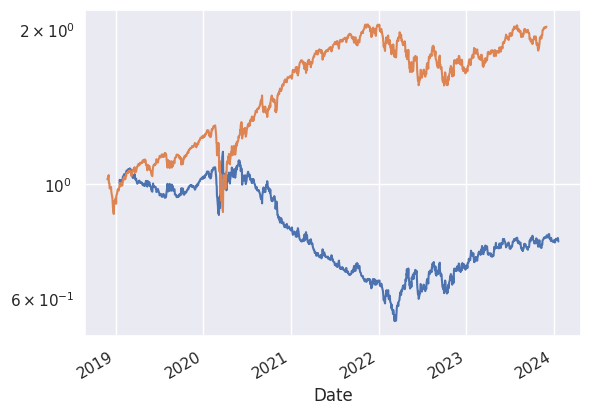

In [ ]:
ax = np.exp(reg_ret.iloc[-252*5:].cumsum()).plot()
ax.plot(np.exp((ff3['Mkt-RF']+ff3['RF']).iloc[-252*5:].cumsum()))
ax.set_yscale('log')

In [ ]:
df = ff3.copy()
df['reg-rf'] = reg_ret-df['RF']
y = df['reg-rf']
X = sm.add_constant(df.iloc[:,:-2])

model = sm.OLS(y,X)
result = model.fit()

In [ ]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 reg-rf   R-squared:                       0.111
Model:                            OLS   Adj. R-squared:                  0.110
Method:                 Least Squares   F-statistic:                     290.9
Date:                Fri, 19 Jan 2024   Prob (F-statistic):          5.26e-178
Time:                        18:55:42   Log-Likelihood:                 23998.
No. Observations:                7012   AIC:                        -4.799e+04
Df Residuals:                    7008   BIC:                        -4.796e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.141e-05   9.44e-05     -0.227      0.821      -0.000       0.000
Mkt-RF         0.2258      0.008     29.269      0.000       0.211       0.241
SMB           -0.0590      0.015     -3.940      0.000      -0.088      -0.030
HML           -0.0399      0.013     -3.195      0.001      -0.064      -0.015
==============================================================================
Omnibus:                     1638.329   Durbin-Watson:                   2.163
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            77019.034
Skew:                           0.244   Prob(JB):                         0.00
Kurtosis:                      19.229   Cond. No.                         161.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

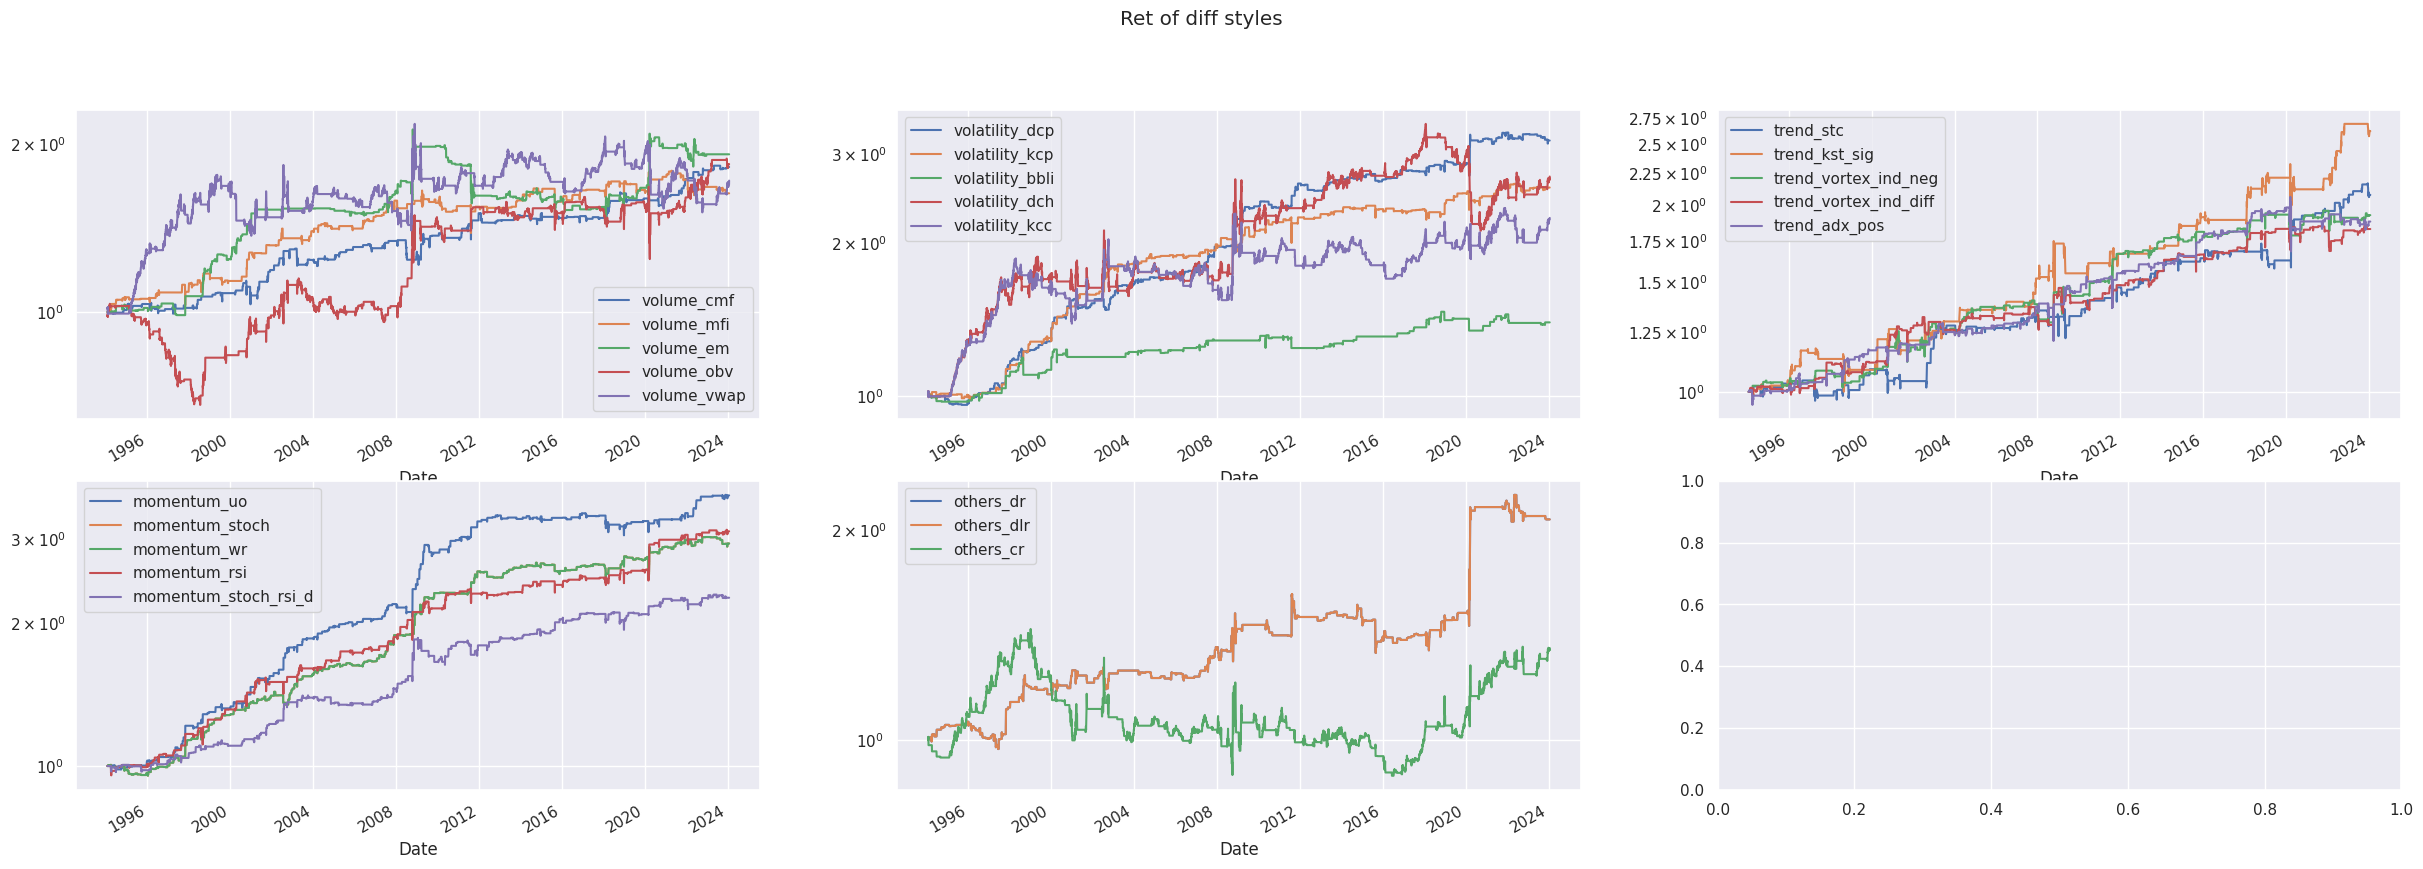

In [ ]:
fig, axes = plt.subplots(2,3,figsize=(30,10))
fig.suptitle('Ret of diff styles')

for i,style in enumerate(shrlist_styles_ret):
  r,c = i//3,i%3
  ax = axes[r,c]
  ax.set_yscale('log')

  np.exp(style.cumsum()).plot(ax=ax)

In [ ]:
avg_style_ret = pd.DataFrame()
for group,style in zip(['vanilla','volume', 'volatility', 'trend', 'momentum', 'others'],styles_ret):
  style_invstd = 1/style.rolling(252).std()
  style_rpw = style_invstd.div(style_invstd.sum(axis=1),axis=0)
  #avg_style_ret[group] = (style*style_rpw).ffill().dropna().sum(axis=1)
  avg_style_ret[group] = style.mean(axis=1)

In [ ]:
group_invstd = 1/avg_style_ret.rolling(252).std()
group_rpw = group_invstd.div(group_invstd.sum(axis=1),axis=0)
#avg_group_ret = (avg_style_ret*group_rpw).ffill().dropna().sum(axis=1)
avg_group_ret = avg_style_ret.mean(axis=1)

mean: 0.02 std: 0.03 sr: 0.62


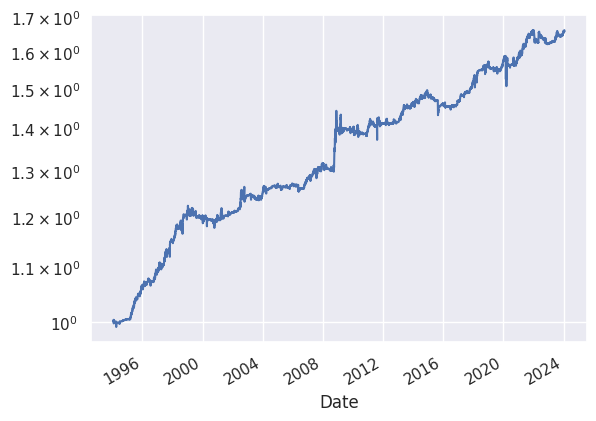

In [ ]:
m = avg_group_ret.mean()*252
s = avg_group_ret.std()*np.sqrt(252)
sr = m/s
print(f'mean: {m:.2f} std: {s:.2f} sr: {sr:.2f}')
ax = np.exp(avg_group_ret.cumsum()).plot()
ax.set_yscale('log')

In [ ]:
avg_group_ret.index

DatetimeIndex(['1996-01-24', '1996-01-25', '1996-01-26', '1996-01-29',
               '1996-01-30', '1996-01-31', '1996-02-01', '1996-02-02',
               '1996-02-05', '1996-02-06',
               ...
               '2024-01-05', '2024-01-08', '2024-01-09', '2024-01-10',
               '2024-01-11', '2024-01-12', '2024-01-16', '2024-01-17',
               '2024-01-18', '2024-01-19'],
              dtype='datetime64[ns]', name='Date', length=7045, freq=None)

In [ ]:
from datetime import datetime as dt
ff_reader = pdr.famafrench.FamaFrenchReader('F-F_Research_Data_Factors_daily',start='1900-01-01',end=str(dt.today()))
ff3 = ff_reader.read()[0]
ff_reader.close()

In [ ]:
ff3 = ff3/100

In [ ]:
ff3

,Mkt-RF,SMB,HML,RF
Date,,,,
1926-07-01,0.0010,-0.0025,-0.0027,0.00009
1926-07-02,0.0045,-0.0033,-0.0006,0.00009
1926-07-06,0.0017,0.0030,-0.0039,0.00009
1926-07-07,0.0009,-0.0058,0.0002,0.00009
1926-07-08,0.0021,-0.0038,0.0019,0.00009
...,...,...,...,...
2023-11-24,0.0011,0.0059,0.0019,0.00021
2023-11-27,-0.0023,-0.0011,-0.0008,0.00021
2023-11-28,0.0006,-0.0029,0.0005,0.00021


0.6183711485444722


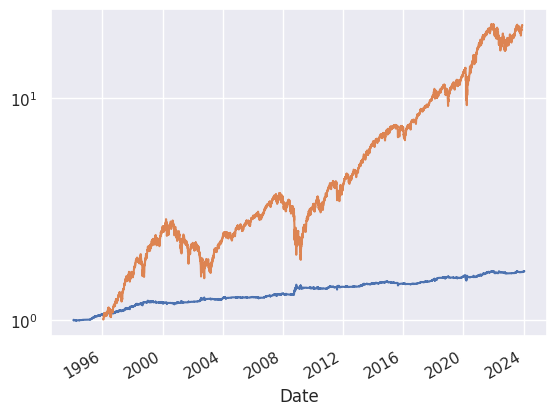

In [ ]:
print(avg_group_ret.mean()/avg_group_ret.std()*np.sqrt(252))
ax = np.exp(avg_group_ret.cumsum()).plot()
ax.plot(np.exp((ff3['Mkt-RF']+ff3['RF']).cumsum()))
ax.set_yscale('log')

In [ ]:
df = ff3.copy()
df['reg-rf'] = reg_ret-df['RF']
y = df['reg-rf']
X = sm.add_constant(df.iloc[:,:-2])

model = sm.OLS(y,X)
result = model.fit()

In [ ]:
combined_shrtlist_styles_ret = pd.concat(shrlist_styles_ret, axis=1)

In [ ]:
combined_shrtlist_styles_ret['spy'] = spy_lnret
combined_shrtlist_styles_ret.dropna(inplace=True)

In [ ]:
y = combined_shrtlist_styles_ret['spy']
X = sm.add_constant(combined_shrtlist_styles_ret.iloc[:,:-1])

model = sm.OLS(y,X)
result = model.fit()

In [ ]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    spy   R-squared:                       0.228
Model:                            OLS   Adj. R-squared:                  0.226
Method:                 Least Squares   F-statistic:                     105.8
Date:                Fri, 19 Jan 2024   Prob (F-statistic):               0.00
Time:                        19:28:02   Log-Likelihood:                 23662.
No. Observations:                7547   AIC:                        -4.728e+04
Df Residuals:                    7525   BIC:                        -4.713e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.0002      0.000      1.789      0.074   -2.08e-05       0.000
volume_cmf                0.0026      0.045      0.058      0.953      -0.085       0.090
volume_mfi                0.1377      0.042      3.258      0.001       0.055       0.221
volume_em                -0.0151      0.032     -0.468      0.640      -0.078       0.048
volume_obv                0.3247      0.026     12.434      0.000       0.273       0.376
volume_vwap              -0.0970      0.046     -2.130      0.033      -0.186      -0.008
volatility_dcp            0.0224      0.057      0.391      0.695      -0.090       0.135
volatility_kcp            0.0775      0.049      1.578      0.115      -0.019       0.174
volatility_bbli           0.7353      0.058     12.644      0.000       0.621       0.849
volatility_dch            0.2516      0.027      9.445      0.000       0.199       0.304
volatility_kcc           -0.0514      0.045     -1.151      0.250      -0.139       0.036
trend_stc                -0.1775      0.037     -4.768      0.000      -0.251      -0.105
trend_kst_sig             0.4351      0.027     15.961      0.000       0.382       0.489
trend_vortex_ind_neg      0.4457      0.050      8.946      0.000       0.348       0.543
trend_vortex_ind_diff    -0.1230      0.054     -2.261      0.024      -0.230      -0.016
trend_adx_pos             0.1096      0.039      2.817      0.005       0.033       0.186
momentum_uo              -0.2875      0.048     -5.968      0.000      -0.382      -0.193
momentum_stoch            0.0564      0.031      1.809      0.070      -0.005       0.117
momentum_wr               0.0564      0.031      1.809      0.070      -0.005       0.117
momentum_rsi              0.0624      0.048      1.314      0.189      -0.031       0.156
momentum_stoch_rsi_d      0.0881      0.043      2.050      0.040       0.004       0.172
others_dr                 0.0094      0.016      0.584      0.559      -0.022       0.041
others_dlr                0.0094      0.016      0.584      0.559      -0.022       0.041
others_cr                -0.0542      0.033     -1.640      0.101      -0.119       0.011
==============================================================================
Omnibus:                     1261.836   Durbin-Watson:                   2.048
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11163.885
Skew:                          -0.539   Prob(JB):                         0.00
Kurtosis:                       8.860   Cond. No.                     1.18e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.42e-33. This might indicate that there are
str